In [1]:
from os import walk
from os.path import join

import pandas as pd
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import PorterStemmer

from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
EXAMPLE_FILE = 'SpamData/01_Processing/practice_email.txt'

SPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_1'
SPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/spam_2'
EASY_NONSPAM_1_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_1'
EASY_NONSPAM_2_PATH = 'SpamData/01_Processing/spam_assassin_corpus/easy_ham_2'

# spam category -> 0 & ham category -> 1
SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = 'SpamData/01_Processing/email-text-data.json'
WORD_ID_FILE = 'SpamData/01_Processing/word-by-id.csv'

TRAINING_DATA_FILE = 'SpamData/02_Training/train-data.txt'
TEST_DATA_FILE = 'SpamData/02_Training/test-data.txt'

WHALE_FILE = 'DATA/wordcloud_resources/whale-icon.png'
SKULL_FILE = 'DATA/wordcloud_resources/skull-icon.png'
THUMBS_UP_FILE = 'DATA/wordcloud_resources/thumbs-up.png'
THUMBS_DOWN_FILE = 'DATA/wordcloud_resources/thumbs-down.png'
CUSTOM_FONT_FILE = 'DATA/wordcloud_resources/OpenSansCondensed-Bold.ttf'

In [3]:
stream = open(EXAMPLE_FILE, encoding='latin-1')
message = stream.read()
stream.close()

print(type(message))
print(message)

<class 'str'>
From exmh-workers-admin@redhat.com  Thu Aug 22 12:36:23 2002
Return-Path: <exmh-workers-admin@spamassassin.taint.org>
Delivered-To: zzzz@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id D03E543C36
	for <zzzz@localhost>; Thu, 22 Aug 2002 07:36:16 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 12:36:16 +0100 (IST)
Received: from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7MBYrZ04811 for
    <zzzz-exmh@spamassassin.taint.org>; Thu, 22 Aug 2002 12:34:53 +0100
Received: from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 8386540858; Thu, 22 Aug 2002
    07:35:02 -0400 (EDT)
Delivered-To: exmh-workers@listman.spamassassin.taint.org
Received: fro

In [4]:
import sys
sys.getfilesystemencoding()

'utf-8'

In [5]:
stream = open(EXAMPLE_FILE, encoding='latin-1')

is_body = False
lines = []

for line in stream:
    if is_body:
        lines.append(line)
    elif line == '\n':
        is_body = True

stream.close()

email_body = ''.join(lines)
print(email_body)



Dear Mr Still

Good tidings to you and all your staff for the festive season ahead (Christmas).
Now to the crux of the matter-in-hand: I am a fully qualified Santa Claus and am wondering whether you might consider me to run my own "Santa's Grotto" in your store.
But WAIT! You're probably thinking: "What makes him so special?"
Well, first of all, I have made several changes to the characterisation of Father Christmas. Rather than greeting the children with shouts of "Ho, ho, ho!" I prefer to whisper the phrase "Dependence is not unfathomable in this cruel world we live in". In addition, my gifts are ALL hand-made, ranging from felt hoops to vanilla-pod holders.
You will note also, from the enclosed sketch, that I have radically redesigned Santa's outfit and have renamed my character "Lord Buckles". Would you be interested in employing me? I promise NEVER to let you down.
I look forward to hearing from you.

Best wishes
Robin Cooper
[Excerpt from the book: The Timewaster Letters by Robi

# Generator Functions

In [6]:
def generate_squares(N):
    for my_number in range(N):
        yield my_number ** 2

In [7]:
for i in generate_squares(5):
    print(i, end=' ->')

0 ->1 ->4 ->9 ->16 ->

## Email body extraction

In [8]:
def email_body_generator(path):
    
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            
            filepath = join(root, file_name)
            
            stream = open(filepath, encoding='latin-1')

            is_body = False
            lines = []

            for line in stream:
                if is_body:
                    lines.append(line)
                elif line == '\n':
                    is_body = True

            stream.close()

            email_body = '\n'.join(lines)
            
            yield file_name, email_body


In [9]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    
    for file_name, email_body in email_body_generator(path):
        rows.append({'MESSAGE': email_body, 'CATEGORY': classification})
        row_names.append(file_name)
        
    return pd.DataFrame(rows, index=row_names)

In [10]:
spam_emails = df_from_directory(SPAM_1_PATH, 1)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, 1))
spam_emails.head()

,MESSAGE,CATEGORY
00341.99b463b92346291f5848137f4a253966,This is a multi-part message in MIME format.\n...,1
00122.98bcaad36eb81e75911371f841f28dfc,Below is the result of your feedback form. It...,1
00078.6944f51ce9c0586d8f9137d2d2207df0,------=_NextPart_000_00D7_08E60D5B.E5437E70\n\...,1
00359.4ab70de20a198b736ed01940c9745384,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1
00161.ae33257753c9bdaaadc9221347868496,"HI, zzzz@spamassassin.taint.org today,\n\n<...",1


In [11]:
spam_emails.shape

(1898, 2)

In [12]:
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
ham_emails.shape

(3901, 2)

In [13]:
data = pd.concat([spam_emails, ham_emails])
print('Shape of entire dataframe is ', data.shape)
data.head()

Shape of entire dataframe is  (5799, 2)


,MESSAGE,CATEGORY
00341.99b463b92346291f5848137f4a253966,This is a multi-part message in MIME format.\n...,1
00122.98bcaad36eb81e75911371f841f28dfc,Below is the result of your feedback form. It...,1
00078.6944f51ce9c0586d8f9137d2d2207df0,------=_NextPart_000_00D7_08E60D5B.E5437E70\n\...,1
00359.4ab70de20a198b736ed01940c9745384,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1
00161.ae33257753c9bdaaadc9221347868496,"HI, zzzz@spamassassin.taint.org today,\n\n<...",1


# Data Cleaning: Checking for Missing Values

In [14]:
# check if any message bodies are null
data['MESSAGE'].isnull().values.any()

False

In [15]:
# check if there are empty emails (string length zero)
(data.MESSAGE.str.len() == 0).any()

True

In [16]:
# Check how many messages are empty
(data.MESSAGE.str.len() == 0).sum()

3

In [17]:
# Check the number of entries with null/None values?
data.MESSAGE.isnull().sum()

0

### Locate empty emails

In [18]:
type(data.MESSAGE.str.len() == 0)

pandas.core.series.Series

In [19]:
data[data.MESSAGE.str.len() == 0].index

Index(['cmds', 'cmds', 'cmds'], dtype='object')

In [20]:
data.drop(['cmds'], inplace=True)

In [21]:
data.shape

(5796, 2)

# Add Document IDs to Track Emails in Dataset

In [22]:
document_ids = range(0, len(data.index))
data['DOC_ID'] = document_ids
data.head()

,MESSAGE,CATEGORY,DOC_ID
00341.99b463b92346291f5848137f4a253966,This is a multi-part message in MIME format.\n...,1,0
00122.98bcaad36eb81e75911371f841f28dfc,Below is the result of your feedback form. It...,1,1
00078.6944f51ce9c0586d8f9137d2d2207df0,------=_NextPart_000_00D7_08E60D5B.E5437E70\n\...,1,2
00359.4ab70de20a198b736ed01940c9745384,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1,3
00161.ae33257753c9bdaaadc9221347868496,"HI, zzzz@spamassassin.taint.org today,\n\n<...",1,4


In [23]:
data['FILE_NAME'] = data.index
data.set_index('DOC_ID', inplace=True)
data.head()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
0,This is a multi-part message in MIME format.\n...,1,00341.99b463b92346291f5848137f4a253966
1,Below is the result of your feedback form. It...,1,00122.98bcaad36eb81e75911371f841f28dfc
2,------=_NextPart_000_00D7_08E60D5B.E5437E70\n\...,1,00078.6944f51ce9c0586d8f9137d2d2207df0
3,OFFICE OF:EGNR. FEMI DANIEL\n\nFEDERAL MINISTR...,1,00359.4ab70de20a198b736ed01940c9745384
4,"HI, zzzz@spamassassin.taint.org today,\n\n<...",1,00161.ae33257753c9bdaaadc9221347868496


# Save to File using Pandas

In [24]:
data.to_json(DATA_JSON_FILE)

# Number of Spam Messages Visualised (Pie Charts)

In [25]:
data.CATEGORY.value_counts()

0    3900
1    1896
Name: CATEGORY, dtype: int64

In [26]:
amount_of_spam = data.CATEGORY.value_counts()[1]
amount_of_ham = data.CATEGORY.value_counts()[0]

### Pie Charts

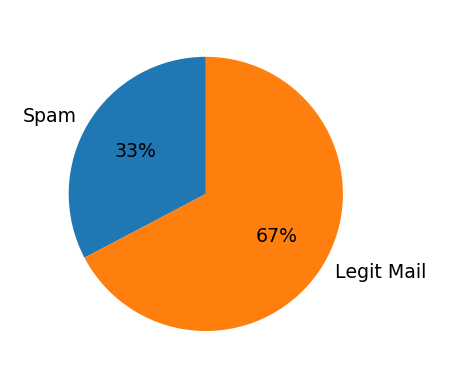

In [27]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%')
plt.show()

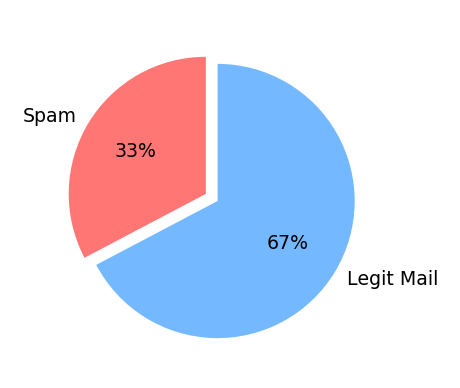

In [28]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colours, explode=[0, 0.1])
plt.show()

### Donut Chart 

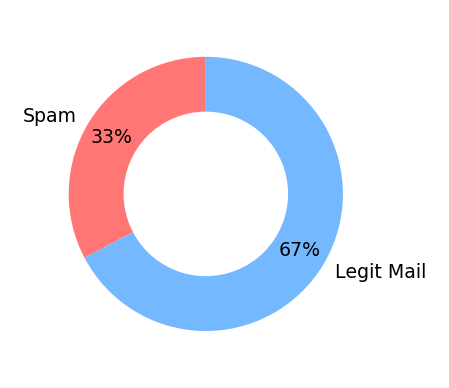

In [29]:
category_names = ['Spam', 'Legit Mail']
sizes = [amount_of_spam, amount_of_ham]
custom_colours = ['#ff7675', '#74b9ff']

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

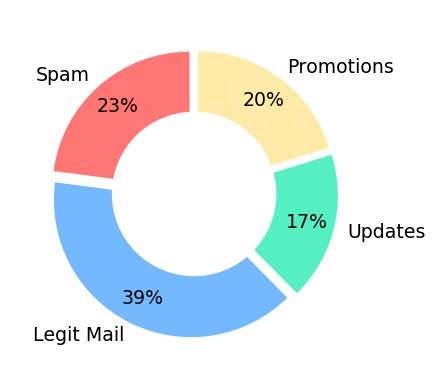

In [30]:
category_names = ['Spam', 'Legit Mail', 'Updates', 'Promotions']
sizes = [25, 43, 19, 22]
custom_colours = ['#ff7675', '#74b9ff', '#55efc4', '#ffeaa7']
offset = [0.05, 0.05, 0.05, 0.05]

plt.figure(figsize=(2, 2), dpi=227)
plt.pie(sizes, labels=category_names, textprops={'fontsize': 6}, startangle=90, autopct='%1.0f%%', colors=custom_colours, pctdistance=0.8, explode=offset)

# draw circle
centre_circle = plt.Circle((0, 0), radius=0.6, fc='white')
plt.gca().add_artist(centre_circle)

plt.show()

# Natural Language Processing

### Text Pre-Processing

In [31]:
# convert to lower case
msg = 'All work and no play makes Jack a dull boy.'
msg.lower()

'all work and no play makes jack a dull boy.'

### Download the NLTK Resources (Tokenizer & Stopwords)

In [32]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gautam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [33]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gautam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [34]:
nltk.download('gutenberg')
nltk.download('shakespeare')

[nltk_data] Downloading package gutenberg to /home/gautam/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package shakespeare to
[nltk_data]     /home/gautam/nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!


True

## Tokenising

In [35]:
msg = 'All work and no play makes Jack a dull boy.'
word_tokenize(msg.lower())

['all', 'work', 'and', 'no', 'play', 'makes', 'jack', 'a', 'dull', 'boy', '.']

## Removing Stop Words 

In [36]:
# Create a set of stop word like a,at,be,i,am....etc
stop_words = set(stopwords.words('english'))

In [37]:
if 'this' in stop_words:
    print('Found it!')

Found it!


### Tokenize words  without stopwords 

In [38]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be.'
words = word_tokenize(msg.lower())

filtered_words = []
for word in words:
    if word not in stop_words:
        filtered_words.append(word)

print(filtered_words)

['work', 'play', 'makes', 'jack', 'dull', 'boy', '.', '.']


### Word Stems and Stemming

In [39]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      I am trying to learn something new about stemming!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words:
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', '.', '.', 'tri', 'learn', 'someth', 'new', 'stem', '!']


### Let's remove all full stop comma and exclamation marks 

In [40]:
msg = 'All work and no play makes Jack a dull boy. To be or not to be. \
      I am trying to learn something new about stemming!'
words = word_tokenize(msg.lower())

# stemmer = PorterStemmer()
stemmer = SnowballStemmer('english')

filtered_words = []
for word in words:
    if word not in stop_words and word.isalpha():
        stemmed_word = stemmer.stem(word)
        filtered_words.append(stemmed_word)

print(filtered_words)

['work', 'play', 'make', 'jack', 'dull', 'boy', 'tri', 'learn', 'someth', 'new', 'stem']


## Removing HTML tags from Emails

### Before HTML parsing from BeautifulSoup

In [41]:
data.at[1, 'MESSAGE']

'Below is the result of your feedback form.  It was submitted by\n\n (jamie@msn.com) on Tuesday, August 27, 2002 at 22:26:56\n\n---------------------------------------------------------------------------\n\n\n\n:: <A HREF="http://www.pornhere.net">click here</A>Don\'t want to pay for Porn? Would you like to get it for FREE? The Honest, No Risk 100% Free Way? If you take a couple of minutes and read through our simple guide you will be able to get Free Passes to the top Paysites online!<A HREF="http://www.pornhere.net">click here</A>\n\n\n\n---------------------------------------------------------------------------\n\n\n\n\n'

### After HTML parsing from BeautifulSoup

In [42]:
soup = BeautifulSoup(data.at[1, 'MESSAGE'], 'html.parser')
print(soup.prettify())

Below is the result of your feedback form.  It was submitted by

 (jamie@msn.com) on Tuesday, August 27, 2002 at 22:26:56

---------------------------------------------------------------------------



::
<a href="http://www.pornhere.net">
 click here
</a>
Don't want to pay for Porn? Would you like to get it for FREE? The Honest, No Risk 100% Free Way? If you take a couple of minutes and read through our simple guide you will be able to get Free Passes to the top Paysites online!
<a href="http://www.pornhere.net">
 click here
</a>
---------------------------------------------------------------------------



In [43]:
soup.get_text()

"Below is the result of your feedback form.  It was submitted by\n\n (jamie@msn.com) on Tuesday, August 27, 2002 at 22:26:56\n\n---------------------------------------------------------------------------\n\n\n\n:: click hereDon't want to pay for Porn? Would you like to get it for FREE? The Honest, No Risk 100% Free Way? If you take a couple of minutes and read through our simple guide you will be able to get Free Passes to the top Paysites online!click here\n\n\n\n---------------------------------------------------------------------------\n\n\n\n\n"

### Let's Create a function which takes message agument and return a clean And tokenize output

In [44]:
def clean_msg_no_html(message):
    
    stop_words=set(stopwords.words('english'))
    stemmer=PorterStemmer()
    
    # Remove HTML tags
    soup = BeautifulSoup(message, 'html.parser')
    cleaned_text = soup.get_text()
    
    # Converts to Lower Case and splits up the words
    words = word_tokenize(cleaned_text.lower())
    
    filtered_words = []
    
    for word in words:
        # Removes the stop words and punctuation
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
        
    return filtered_words

In [45]:
clean_msg_no_html(data.at[3, 'MESSAGE'])

['offic',
 'egnr',
 'femi',
 'daniel',
 'feder',
 'ministri',
 'work',
 'hous',
 'feder',
 'secretariat',
 'offic',
 'complex',
 'attn',
 'first',
 'must',
 'solicit',
 'strictest',
 'confid',
 'transact',
 'virtu',
 'natur',
 'utterli',
 'confidenti',
 'top',
 'secret',
 'introduc',
 'confid',
 'nigeria',
 'chamber',
 'commerc',
 'industri',
 'top',
 'offici',
 'feder',
 'ministri',
 'work',
 'hous',
 'fmw',
 'h',
 'feder',
 'ministri',
 'financ',
 'presid',
 'make',
 'contract',
 'review',
 'panel',
 'crp',
 'set',
 'feder',
 'govern',
 'nigeria',
 'review',
 'contract',
 'award',
 'past',
 'militari',
 'administr',
 'cours',
 'work',
 'crp',
 'discov',
 'fund',
 'result',
 'grossli',
 'invoic',
 'contract',
 'execut',
 'fmw',
 'h',
 'last',
 'compani',
 'execut',
 'contract',
 'duli',
 'paid',
 'contract',
 'commiss',
 'leav',
 'sum',
 'us',
 'million',
 'float',
 'escrow',
 'account',
 'central',
 'bank',
 'nigeria',
 'readi',
 'payment',
 'therefor',
 'mandat',
 'matter',
 'trust'

# Apply Cleaning and Tokenisation to all messages

### Slicing Dataframes and Series & Creating Subsets

Pandas indexing methods (iat[i,j] , iloc[i:j])

In [46]:
# Index at 8th row 2nd column
data.iat[8, 2]

'00194.767c323b4ae7a4909397e42cbd0c56a4'

In [47]:
# slice data from 5th row to 11th row
data.iloc[5:11]

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
5,--------------103227703017104\n\nContent-Type:...,1,00344.17882edad13c2c761e6d8d99eef5a346
6,=?GB2312?B?yNW12squ0ru97NbQufq5+rzKtefX08nosb...,1,00481.5c95b526e965fa325044123c4ce29c1f
7,"Dear zzzzason.org,\n\n\n\nMy name is Andy Koh,...",1,00229.4c37dd3d98b8d6fb2694b6f83061ca5a
8,------=_NextPart_000_006C_6B8D6A65.3C3C56F\n\n...,1,00194.767c323b4ae7a4909397e42cbd0c56a4
9,1) Fight The Risk of Cancer!\n\nhttp://www.adc...,1,00045.7282c2c4e009744f2f3450d370009235
10,Get your favorite Poker action at http://www.m...,1,00294.df27a988d82cc82296e33e6d727ac47e


### Apply .apply() method for first 3 messages

In [48]:
first_emails = data.MESSAGE.iloc[0:3]
nested_list = first_emails.apply(clean_msg_no_html)

print(nested_list)

DOC_ID
0    [messag, mime, format, dear, wish, wonder, off...
1    [result, feedback, form, submit, jami, tuesday...
2                                                   []
Name: MESSAGE, dtype: object


### Apply .apply() method for first all messages and print total time consumed 

In [49]:
%%time

nested_list = data.MESSAGE.apply(clean_msg_no_html)

/home/gautam/miniconda3/envs/ml-assessment/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


CPU times: user 1min 1s, sys: 187 ms, total: 1min 1s
Wall time: 1min 1s


In [50]:
nested_list.tail()

DOC_ID
5791    [thu, john, looney, wrote, instal, redhat, dis...
5792    [sat, aug, kevin, lyda, wrote, site, like, mak...
5793    [hm, look, good, http, kevin, kevin, believ, h...
5794    [pm, russel, turpin, wrote, person, would, kno...
5795    [use, perl, daili, newslett, issu, last, call,...
Name: MESSAGE, dtype: object

In [51]:
data[data.CATEGORY == 1].shape

(1896, 3)

In [52]:
data[data.CATEGORY == 1].tail()

,MESSAGE,CATEGORY,FILE_NAME
DOC_ID,,,
1891,\n\n\n\nYOU CAN MAKE A SEA OF DIFFERENCE\n\n\n...,1,00139.cee7452bc16a8e26ea1ad841321c95ce
1892,<html><body><center><a href=http://www.vitafac...,1,00213.b85553a858843eabb7752c6d15aaba5a
1893,------=_NextPart_84815C5ABAF209EF376268C8\n\nC...,1,01246.d0ee9c7ebf9d953b21de9414cc96c2f9
1894,\n\n<html>\n\n<head>\n\n<title>Untitled Docume...,1,00317.902b19a36e88cd3ad096e736ff8c81a5
1895,--===_SecAtt_000_1fdcynbjtbpkdh\n\nContent-Typ...,1,01240.7d6ae3682a3dd3fe457516b188eb105c


#### Dealing With Ham Messages

In [53]:
# store index of ham message
doc_ids_ham = data[data.CATEGORY == 0].index

In [54]:
doc_ids_ham

Int64Index([1896, 1897, 1898, 1899, 1900, 1901, 1902, 1903, 1904, 1905,
            ...
            5786, 5787, 5788, 5789, 5790, 5791, 5792, 5793, 5794, 5795],
           dtype='int64', name='DOC_ID', length=3900)

In [55]:
type(doc_ids_ham)

pandas.core.indexes.numeric.Int64Index

In [56]:
type(nested_list)

pandas.core.series.Series

In [57]:
# Store all ham data in nested_list_ham
nested_list_ham = nested_list.loc[doc_ids_ham]

In [58]:
nested_list_ham.shape

(3900,)

In [59]:
# Display tail of ham data 
nested_list_ham.tail()

DOC_ID
5791    [thu, john, looney, wrote, instal, redhat, dis...
5792    [sat, aug, kevin, lyda, wrote, site, like, mak...
5793    [hm, look, good, http, kevin, kevin, believ, h...
5794    [pm, russel, turpin, wrote, person, would, kno...
5795    [use, perl, daili, newslett, issu, last, call,...
Name: MESSAGE, dtype: object

In [60]:
# Find the total number of words in our clean datashet
# there is list inside list 

flat_list_ham = [item for sublist in nested_list_ham for item in sublist]
non_spam_words = pd.Series(flat_list_ham).value_counts()

print('Total words in non spam email : ',non_spam_words.shape[0])

Total words in non spam email :  20815


In [61]:
# Top 10 most common/frequently used words in Non-Spam-Email

non_spam_words[:10]

http      7563
use       3633
list      2880
one       2373
get       2286
mail      2255
would     2003
like      1931
messag    1849
work      1800
dtype: int64

#### Dealing With Spam Messages

In [62]:
# store index of spam and ham message in seperate variable
doc_ids_spam = data[data.CATEGORY == 1].index

In [63]:
# Store all ham data in nested_list_ham
nested_list_spam = nested_list.loc[doc_ids_spam]

In [64]:
# Find the total number of words in our clean datashet
# there is list inside list 

flat_list_spam = [item for sublist in nested_list_spam for item in sublist]
spam_words = pd.Series(flat_list_spam).value_counts()

print('Total words in spam email : ',spam_words.shape[0])

Total words in spam email :  13242


In [65]:
spam_words[:10]

http      3097
email     3090
free      2585
click     2058
receiv    1989
list      1971
get       1914
pleas     1852
busi      1792
order     1746
dtype: int64

# Creating a Word Cloud

#### Word cloud helps to visualize frequently used words in string

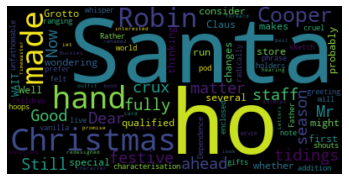

In [66]:
word_cloud = WordCloud().generate(email_body)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [67]:
# Load Novel From nltk corpus
example_corpus = nltk.corpus.gutenberg.words('melville-moby_dick.txt')
len(example_corpus)

260819

In [68]:
type(example_corpus)

nltk.corpus.reader.util.StreamBackedCorpusView

In [69]:
example_corpus

['[', 'Moby', 'Dick', 'by', 'Herman', 'Melville', ...]

In [70]:
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

In [71]:
novel_as_string

'[ Moby Dick by Herman Melville 1851 ] ETYMOLOGY . ( Supplied by a Late Consumptive Usher to a Grammar School ) The pale Usher -- threadbare in coat , heart , body , and brain ; I see him now . He was ever dusting his old lexicons and grammars , with a queer handkerchief , mockingly embellished with all the gay flags of all the known nations of the world . He loved to dust his old grammars ; it somehow mildly reminded him of his mortality . " While you take in hand to school others , and to teach them by what name a whale - fish is to be called in our tongue leaving out , through ignorance , the letter H , which almost alone maketh the signification of the word , you deliver that which is not true ." -- HACKLUYT " WHALE . ... Sw . and Dan . HVAL . This animal is named from roundness or rolling ; for in Dan . HVALT is arched or vaulted ." -- WEBSTER \' S DICTIONARY " WHALE . ... It is more immediately from the Dut . and Ger . WALLEN ; A . S . WALW - IAN , to roll , to wallow ." -- RICHA

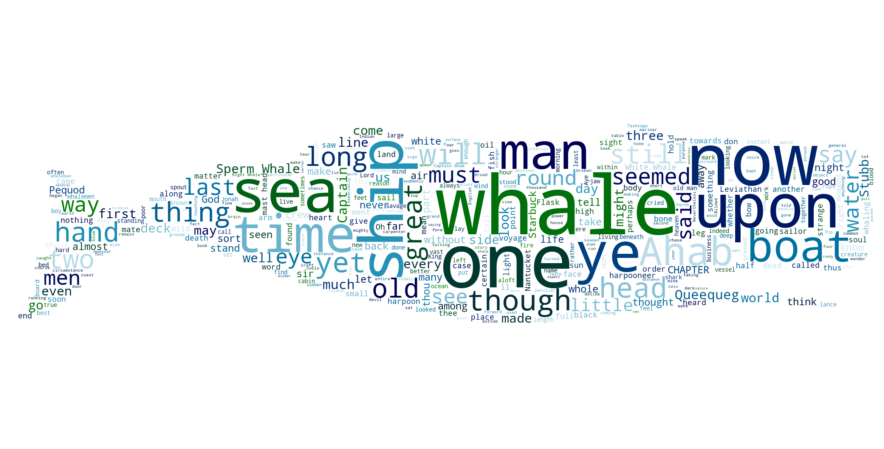

In [72]:
icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=400, colormap='ocean')

word_cloud.generate(novel_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [73]:
rgb_array.shape

(1024, 2048, 3)

In [74]:
rgb_array[1023, 2047]

array([255, 255, 255], dtype=uint8)

In [75]:
rgb_array[456, 1000]

array([0, 0, 0], dtype=uint8)

## Word Cloud Of shakespeare-hamlet Over Skull 

In [76]:
hamlet_corpus = nltk.corpus.gutenberg.words('shakespeare-hamlet.txt')
word_list = [''.join(word) for word in hamlet_corpus]
hamlet_as_string = ' '.join(word_list)

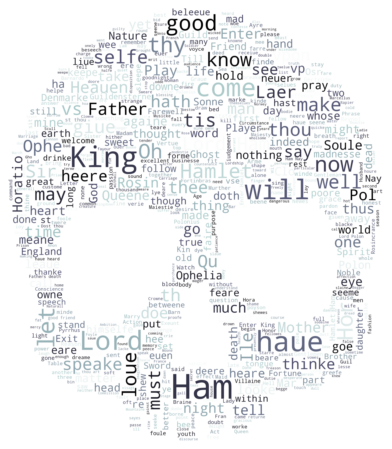

In [77]:
icon = Image.open(SKULL_FILE)

# Create A Blank White Image
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
# Paste Image Over Mask 
image_mask.paste(icon, box=icon)
# converts the image object to an array
rgb_array = np.array(image_mask)

# Create a word cloud
word_cloud = WordCloud(mask=rgb_array, background_color='white',colormap='bone', max_words=600)
word_cloud.generate(hamlet_as_string)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

## Word Cloud of Ham and Spam Messages

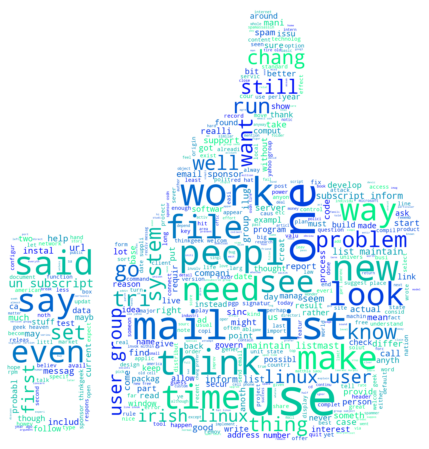

In [78]:
icon = Image.open(THUMBS_UP_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

ham_str = ' '.join(flat_list_ham)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_words=500, colormap='winter')
word_cloud.generate(ham_str)

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

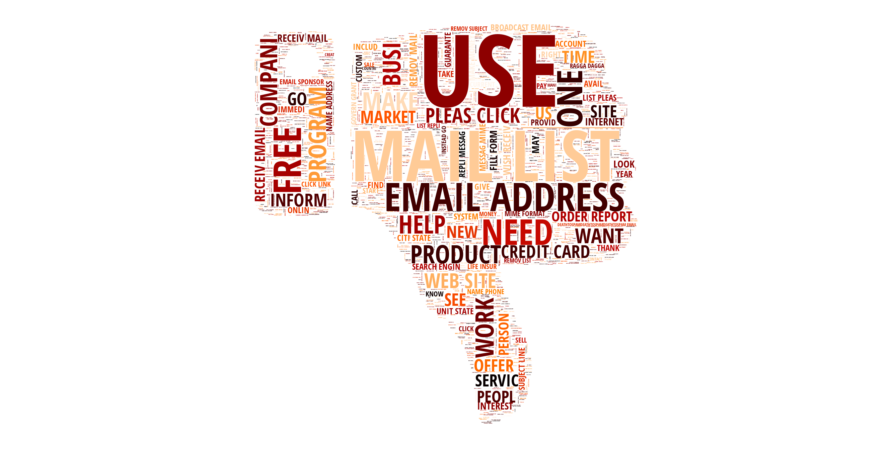

In [79]:
icon = Image.open(THUMBS_DOWN_FILE)
image_mask = Image.new(mode='RGB', size=icon.size, color=(255, 255, 255))
image_mask.paste(icon, box=icon)

rgb_array = np.array(image_mask) # converts the image object to an array

# Generate the text as a string for the word cloud
spam_str = ' '.join(flat_list_spam)

word_cloud = WordCloud(mask=rgb_array, background_color='white', max_font_size=300,max_words=2000, colormap='gist_heat', font_path=CUSTOM_FONT_FILE)

word_cloud.generate(spam_str.upper())

plt.figure(figsize=[16, 8])
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Generate Vocabulary & Dictionary

In [80]:
stemmed_nested_list = data.MESSAGE.apply(clean_msg_no_html)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

/home/gautam/miniconda3/envs/ml-assessment/lib/python3.8/site-packages/bs4/__init__.py:414: MarkupResemblesLocatorWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  warnings.warn(


In [81]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
print('Nr of unique words', unique_words.shape[0])
unique_words.head()

Nr of unique words 27334


http     10660
use       5019
list      4851
email     4367
get       4200
dtype: int64

In [82]:
frequent_words = unique_words[0:VOCAB_SIZE]
print('Most common words: \n', frequent_words[:10])

Most common words: 
 http     10660
use       5019
list      4851
email     4367
get       4200
mail      3983
one       3907
free      3202
time      3042
work      2883
dtype: int64


## Create Vocabulary DataFrame with a WORD_ID

In [83]:
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({'VOCAB_WORD': frequent_words.index.values}, index=word_ids)
vocab.index.name = 'WORD_ID'
vocab.head()

,VOCAB_WORD
WORD_ID,
0,http
1,use
2,list
3,email
4,get


### Save the Vocabulary as a CSV File

In [84]:
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORD.name)

## Checking if a Word is Part of the Vocabulary

In [85]:
any(vocab.VOCAB_WORD == 'machine') # inefficient

False

In [86]:
'brew' in set(vocab.VOCAB_WORD) # better way

False

# Find the Email with the Most Number of Words

In [87]:
clean_email_lengths = []

for sublist in stemmed_nested_list:
    clean_email_lengths.append(len(sublist))

In [88]:
# Python List Comprehension

clean_email_lengths = [len(sublist) for sublist in stemmed_nested_list]
print('Nr words in the longest email:', max(clean_email_lengths))

Nr words in the longest email: 7671


In [89]:
print('Email position in the list (and the data dataframe)', np.argmax(clean_email_lengths))

Email position in the list (and the data dataframe) 5590


In [90]:
stemmed_nested_list[np.argmax(clean_email_lengths)]

['yahoo',
 'group',
 'sponsor',
 'dvd',
 'free',
 'p',
 'join',
 'http',
 'new',
 'version',
 'unison',
 'avail',
 'test',
 'incorpor',
 'sever',
 'small',
 'improv',
 'main',
 'chang',
 'fix',
 'bug',
 'potenti',
 'seriou',
 'safeti',
 'consequ',
 'small',
 'number',
 'user',
 'habit',
 'run',
 'one',
 'instanc',
 'unison',
 'time',
 'parallel',
 'user',
 'strongli',
 'encourag',
 'upgrad',
 'other',
 'wait',
 'wish',
 'releas',
 'includ',
 'execut',
 'linux',
 'solari',
 'window',
 'look',
 'maintain',
 'moment',
 'none',
 'activ',
 'develop',
 'regularli',
 'use',
 'unison',
 'window',
 'machin',
 'configur',
 'properli',
 'build',
 'execut',
 'export',
 'grab',
 'http',
 'enjoy',
 'benjamin',
 'chang',
 'sinc',
 'ad',
 'prefer',
 'maxthread',
 'use',
 'limit',
 'number',
 'simultan',
 'file',
 'transfer',
 'ad',
 'backupdir',
 'prefer',
 'control',
 'backup',
 'file',
 'store',
 'basic',
 'support',
 'ad',
 'osx',
 'particular',
 'unison',
 'recogn',
 'one',
 'host',
 'synchron',
 

In [91]:
data.at[np.argmax(clean_email_lengths), 'MESSAGE']

'------------------------ Yahoo! Groups Sponsor ---------------------~-->\n\n4 DVDs Free +s&p Join Now\n\nhttp://us.click.yahoo.com/pt6YBB/NXiEAA/Ey.GAA/26EolB/TM\n\n---------------------------------------------------------------------~->\n\n\n\nA new version of unison is now available for testing.  It incorporates\n\nseveral small improvements over 2.9.1, but the main change is a fix to\n\na bug that had potentially serious safety consequences, but only for\n\nthe very small number of users that are in the habit of running more\n\nthan one instance of Unison at a time, in parallel.  These users are\n\nstrongly encouraged to upgrade.  Others can wait if they wish.\n\n\n\nThe release includes pre-built executables for Linux and Solaris, but\n\nnot Windows.  (We are looking for a Unison-Windows maintainer -- at\n\nthe moment, none of the active developers are regularly using Unison\n\non Windows, and we do not have a machine that is configured properly\n\nfor building executables for exp

# Generate Features & a Sparse Matrix

### Creating a DataFrame with one Word per Column

In [92]:
type(stemmed_nested_list)

pandas.core.series.Series

In [93]:
type(stemmed_nested_list.tolist())

list

In [94]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())
word_columns_df.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
0,messag,mime,format,dear,wish,wonder,offer,save,money,shop,...,None,None,None,None,None,None,None,None,None,None
1,result,feedback,form,submit,jami,tuesday,august,click,heredo,want,...,None,None,None,None,None,None,None,None,None,None
2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,offic,egnr,femi,daniel,feder,ministri,work,hous,feder,secretariat,...,None,None,None,None,None,None,None,None,None,None
4,hi,zzzz,today,ink,price,would,like,get,spacial,offer,...,None,None,None,None,None,None,None,None,None,None


In [95]:
word_columns_df.shape

(5796, 7671)

### Splitting the Data into a Training and Testing Dataset

In [96]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data.CATEGORY,test_size=0.3, random_state=42)

In [97]:
print('Nr of training samples', X_train.shape[0])
print('Fraction of training set', X_train.shape[0] / word_columns_df.shape[0])

Nr of training samples 4057
Fraction of training set 0.6999654934437544


In [98]:
X_train.index.name = X_test.index.name = 'DOC_ID'
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4844,fri,jul,brian,foster,claim,think,like,classic,techniqu,roll,...,None,None,None,None,None,None,None,None,None,None
4727,quot,ronan,waid,sure,soft,link,would,honest,tri,think,...,None,None,None,None,None,None,None,None,None,None
5022,mani,good,musician,joke,young,lutheran,guid,orchestra,cheer,wayn,...,None,None,None,None,None,None,None,None,None,None
3504,wed,gari,lawrenc,murphi,wrote,java,program,due,extens,class,...,None,None,None,None,None,None,None,None,None,None
3921,know,simpl,symlink,kernel,sourc,directori,also,fri,ben,liblit,...,None,None,None,None,None,None,None,None,None,None


In [99]:
y_train.head()

DOC_ID
4844    0
4727    0
5022    0
3504    0
3921    0
Name: CATEGORY, dtype: int64

### Create a Sparse Matrix for the Training Data

In [100]:
word_index = pd.Index(vocab.VOCAB_WORD)
type(word_index[3])

str

In [101]:
word_index.get_loc('thu')

394

In [102]:
def make_sparse_matrix(df, indexed_words, labels):
    """
    Returns sparse matrix as dataframe.
    
    df: A dataframe with words in the columns with a document id as an index (X_train or X_test)
    indexed_words: index of words ordered by word id
    labels: category as a series (y_train or y_test)
    """
    
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    dict_list = []
    
    for i in range(nr_rows):
        for j in range(nr_cols):
            
            word = df.iat[i, j]
            if word in word_set:
                doc_id = df.index[i]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                
                item = {'LABEL': category, 'DOC_ID': doc_id,
                       'OCCURENCE': 1, 'WORD_ID': word_id}
                
                dict_list.append(item)
    
    return pd.DataFrame(dict_list)

In [103]:
%%time
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

CPU times: user 4min 28s, sys: 214 ms, total: 4min 28s
Wall time: 4min 28s


In [104]:
sparse_train_df

,LABEL,DOC_ID,OCCURENCE,WORD_ID
0,0,4844,1,741
1,0,4844,1,493
2,0,4844,1,1188
3,0,4844,1,376
4,0,4844,1,53
...,...,...,...,...
445836,1,860,1,158
445837,1,860,1,17
445838,1,860,1,169
445839,1,860,1,3


In [105]:
sparse_train_df.shape

(445841, 4)

In [106]:
sparse_train_df[-5:]

,LABEL,DOC_ID,OCCURENCE,WORD_ID
445836,1,860,1,158
445837,1,860,1,17
445838,1,860,1,169
445839,1,860,1,3
445840,1,860,1,23


### Combine Occurrences with the Pandas groupby() Method

In [107]:
train_grouped = sparse_train_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum()
train_grouped.head()

OCCURENCE
DOC_ID WORD_ID LABEL           
0      0       1              1
       1       1              1
       2       1              4
       3       1             10
       5       1              1

In [108]:
vocab.at[0, 'VOCAB_WORD']

'http'

In [109]:
data.MESSAGE[0]

'This is a multi-part message in MIME format.\n\n\n\n------=_NextPart_000_01BC2B74.89D1CCC0\n\nContent-Type: multipart/alternative; \n\n\tboundary="----=_NextPart_84815C5ABAF209EF376268C8"\n\n\n\n------=_NextPart_84815C5ABAF209EF376268C8\n\nContent-type: text/plain; charset=windows-1252\n\nContent-Transfer-Encoding: quoted-printable\n\n\n\nDear Sir/Madam\n\n\n\nWishing you a wonderful day=2E  With an offer, to save you money and  time=\n\n=2E Shopping from the convenience from  home or office=2E\n\nWindow shopping, A new way to go window shopping=2E Our online super store=\n\n offers over 1500 quality products, with 15 plus categories=2E\n\nFor you to, window shop through=2E=20\n\n\n\nThe following are E-coupons numbers, which you can use with any order=2E Y=\n\nou place from Johnson Home Products Online Super Store=2E\n\nDuring the check out process of our online secure shopping cart system ord=\n\ner form, you will be prompt to enter in the E-coupon\n\nnumber=2E which will give you, 

In [110]:
train_grouped = train_grouped.reset_index()
train_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,0,0,1,1
1,0,1,1,1
2,0,2,1,4
3,0,3,1,10
4,0,5,1,1


In [111]:
train_grouped.tail()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
266915,5795,1929,0,1
266916,5795,2145,0,1
266917,5795,2221,0,1
266918,5795,2393,0,1
266919,5795,2440,0,1


In [112]:
vocab.at[1923, 'VOCAB_WORD']

'hmm'

In [113]:
data.MESSAGE[5795]

'use Perl Daily Newsletter\n\n\n\nIn this issue:\n\n    * Last Call for Papers for YAPC::Europe::2002\n\n    * Perl 5.8.0 Released\n\n    * Parrot 0.0.7 Released\n\n\n\n+--------------------------------------------------------------------+\n\n| Last Call for Papers for YAPC::Europe::2002                        |\n\n|   posted by pudge on Friday July 19, @03:30 (yapce)                |\n\n|   http://use.perl.org/article.pl?sid=02/07/18/1430255              |\n\n+--------------------------------------------------------------------+\n\n\n\n[0]Richard Foley writes "Share your \'pe[a]rls of wisdom\' with the Perl\n\ncommunity: attendees from all around the world, gurus and geeks alike,\n\nwill converge on Munich for [0]YAPC::Europe Sept. 18-20 to listen to the\n\ntalks and tutorials presented at this gathering of minds. This year\'s\n\ntheme is \'The Science of Perl\', which means that we would really like to\n\nhear about suggestions for talks, projects, experiences which involve\n\nboth p

In [114]:
train_grouped.shape

(266920, 4)

### Save Training Data as .txt File

In [115]:
np.savetxt(TRAINING_DATA_FILE, train_grouped, fmt='%d')

In [116]:
train_grouped.columns

Index(['DOC_ID', 'WORD_ID', 'LABEL', 'OCCURENCE'], dtype='object')

# create a sparse matrix for the test data. Group the occurrences of the same word in the same email. Then save the data as a .txt file. 

In [117]:
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
DOC_ID,,,,,,,,,,,,,,,,,,,,,
4675,good,day,zenn,fri,aug,zenn,wrote,see,valid,need,...,None,None,None,None,None,None,None,None,None,None
4220,adam,beberg,wrote,tue,sep,kragen,sitak,wrote,entir,post,...,None,None,None,None,None,None,None,None,None,None
2484,url,http,date,mani,notic,feed,back,hope,soon,sure,...,None,None,None,None,None,None,None,None,None,None
2418,upon,time,angl,wrote,fyi,make,alsa,rpm,peopl,null,...,None,None,None,None,None,None,None,None,None,None
5110,begin,forward,messag,ian,andrew,bell,date,tue,jul,pm,...,None,None,None,None,None,None,None,None,None,None


In [118]:
y_test.head()

DOC_ID
4675    0
4220    0
2484    0
2418    0
5110    0
Name: CATEGORY, dtype: int64

In [119]:
X_test.shape

(1739, 7671)

In [120]:
%%time
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

CPU times: user 1min 53s, sys: 103 ms, total: 1min 53s
Wall time: 1min 53s


In [121]:
sparse_test_df.shape

(186782, 4)

In [122]:
test_grouped = sparse_test_df.groupby(['DOC_ID', 'WORD_ID', 'LABEL']).sum().reset_index()
test_grouped.head()

,DOC_ID,WORD_ID,LABEL,OCCURENCE
0,12,6,1,2
1,12,8,1,1
2,12,16,1,1
3,12,17,1,2
4,12,21,1,2


In [123]:
test_grouped.shape

(109232, 4)

### Save the testing data into text file

In [124]:
np.savetxt(TEST_DATA_FILE, test_grouped, fmt='%d')

# Pre-Processing Discussion

In [125]:
train_doc_ids = set(train_grouped.DOC_ID)
test_doc_ids = set(test_grouped.DOC_ID)

In [126]:
len(test_doc_ids)

1716

In [127]:
len(X_test)

1739

### There are some missing values in sparse matrix  because test data size is not equal to docs in sparse matrix

In [128]:
# Let's find the missing docs id

set(X_test.index.values) - test_doc_ids

{8,
 101,
 184,
 196,
 214,
 263,
 292,
 410,
 473,
 485,
 589,
 693,
 696,
 776,
 807,
 864,
 1189,
 1210,
 1302,
 1371,
 1618,
 1700,
 1760}

### Data is excluded because of vocabulary not matched

In [129]:
data.MESSAGE[101]

'------=_NextPart_000_00C5_22E25E1D.D0727B17\n\nContent-Type: text/plain; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nIA0KICAgICAgICAgICAgICAgICBEbyBZb3UgV2FudCBUbyBUZWFjaCBhbmQg\n\nR3JvdyBSaWNoPw0KDQoNCg0KDQoNCklmIHlvdSBhcmUgYSBtb3RpdmF0ZWQg\n\nYW5kIHF1YWxpZmllZCBjb21tdW5pY2F0b3IsIEkgd2lsbCBwZXJzb25hbGx5\n\nIHRyYWluIHlvdSB0byBkbyAzICAyMCBtaW51dGVzIHByZXNlbnRhdGlvbnMg\n\ncGVyIGRheSB0byBxdWFsaWZ5IHByb3NwZWN0cyB0aGF0IEkgY2FuIHByb3Zp\n\nZGUgdG8geW91LiAgV2Ugd2lsbCBkZW1vbnN0cmF0ZSB0byB5b3UgdGhhdCB5\n\nb3UgY2FuIG1ha2UgJDQwMCBhIGRheSBwYXJ0IHRpbWUgdXNpbmcgdGhpcyBz\n\neXN0ZW0uICBPciwgaWYgeW91IGhhdmUgMjAgaG91cnMgcGVyIHdlZWssIGFz\n\nIGluIG15IGNhc2UsIHlvdSBjYW4gbWFrZSBpbiBleGNlc3Mgb2YgJDEwLDAw\n\nMCBwZXIgd2VlaywgYXMgSSBhbSBjdXJyZW50bHkgZ2VuZXJhdGluZyAodmVy\n\naWZpYWJsZSwgYnkgdGhlIHdheSkuICANCg0KUGx1cyBJIHdpbGwgaW50cm9k\n\ndWNlIHlvdSB0byBteSBtZW50b3Igd2hvIG1ha2VzIHdlbGwgaW4gZXhjZXNz\n\nIG9mICQxLDAwMCwwMDAgYW5udWFsbHkuDQoNCk1hbnkgYXJlIGNhbGxlZCwg\n\nZmV3IGFyZSBjaG9zZW4uICBUa

In [130]:
data.loc[101]

MESSAGE      ------=_NextPart_000_00C5_22E25E1D.D0727B17\n\...
CATEGORY                                                     1
FILE_NAME               00340.520783fd73bb73df88d6effd04e1f55d
Name: 101, dtype: object

In [131]:
clean_msg_no_html(data.at[101, 'MESSAGE'])

[]